In [1]:
from google.colab import files

uploaded = files.upload()

Saving Sample - Superstore.xls to Sample - Superstore.xls


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import itertools
import matplotlib
import joblib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

### Import and Read Data 

In [4]:
df = pd.read_excel("/content/Sample - Superstore.xls")

In [5]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

In [7]:
los_angeles_data = df.loc[df['City'] == 'Los Angeles']

In [8]:
los_angeles_data.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [9]:
del_cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Quantity', 'Discount', 'Profit']
los_angeles_data.drop(del_cols,axis=1,inplace=True)

In [10]:
los_angeles_data.columns

Index(['Order Date', 'Sales'], dtype='object')

In [11]:
los_angeles_data = los_angeles_data.groupby('Order Date').sum().reset_index()


In [12]:
los_angeles_data = los_angeles_data.set_index('Order Date')
los_angeles_data

,Sales
Order Date,
2014-01-06,19.440
2014-01-20,38.660
2014-02-20,12.960
2014-03-23,935.152
2014-03-26,66.300
...,...
2017-12-21,12.510
2017-12-22,474.950
2017-12-24,2970.432


In [13]:
y = los_angeles_data['Sales'].resample('MS').mean()

### Visualizing Data

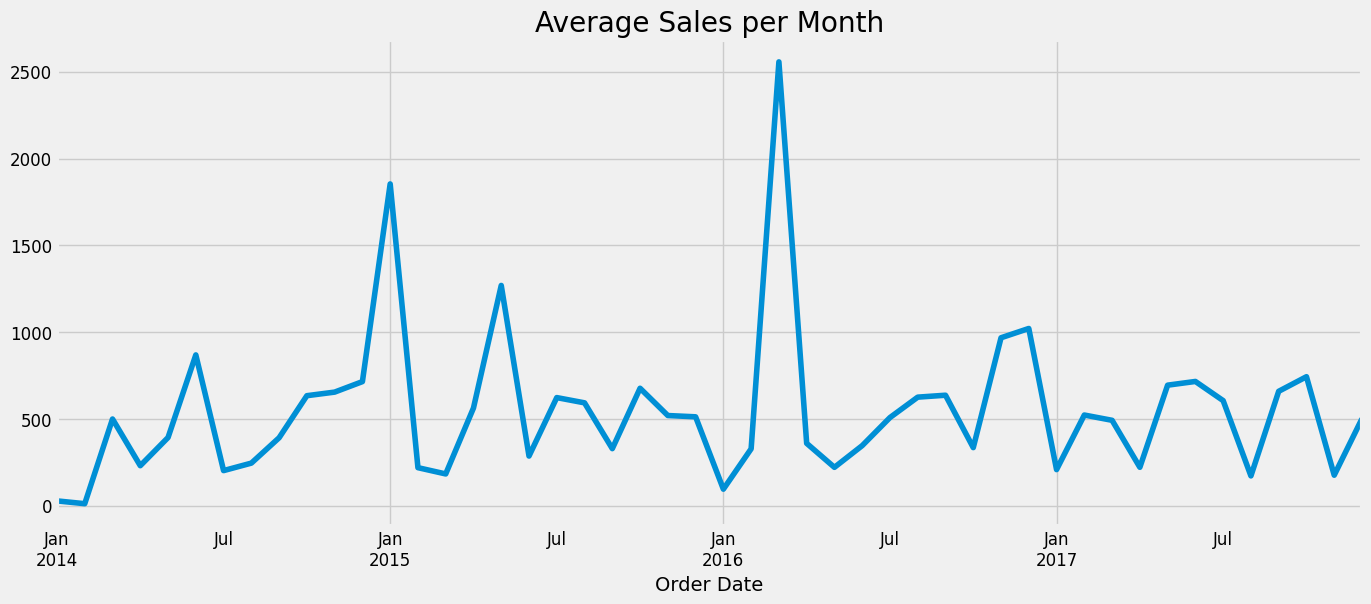

In [14]:
y.plot(figsize=(15,6))
plt.title("Average Sales per Month")
plt.show()


This time series dataset has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of of the year

### Decompose to seasonality, trend and noise

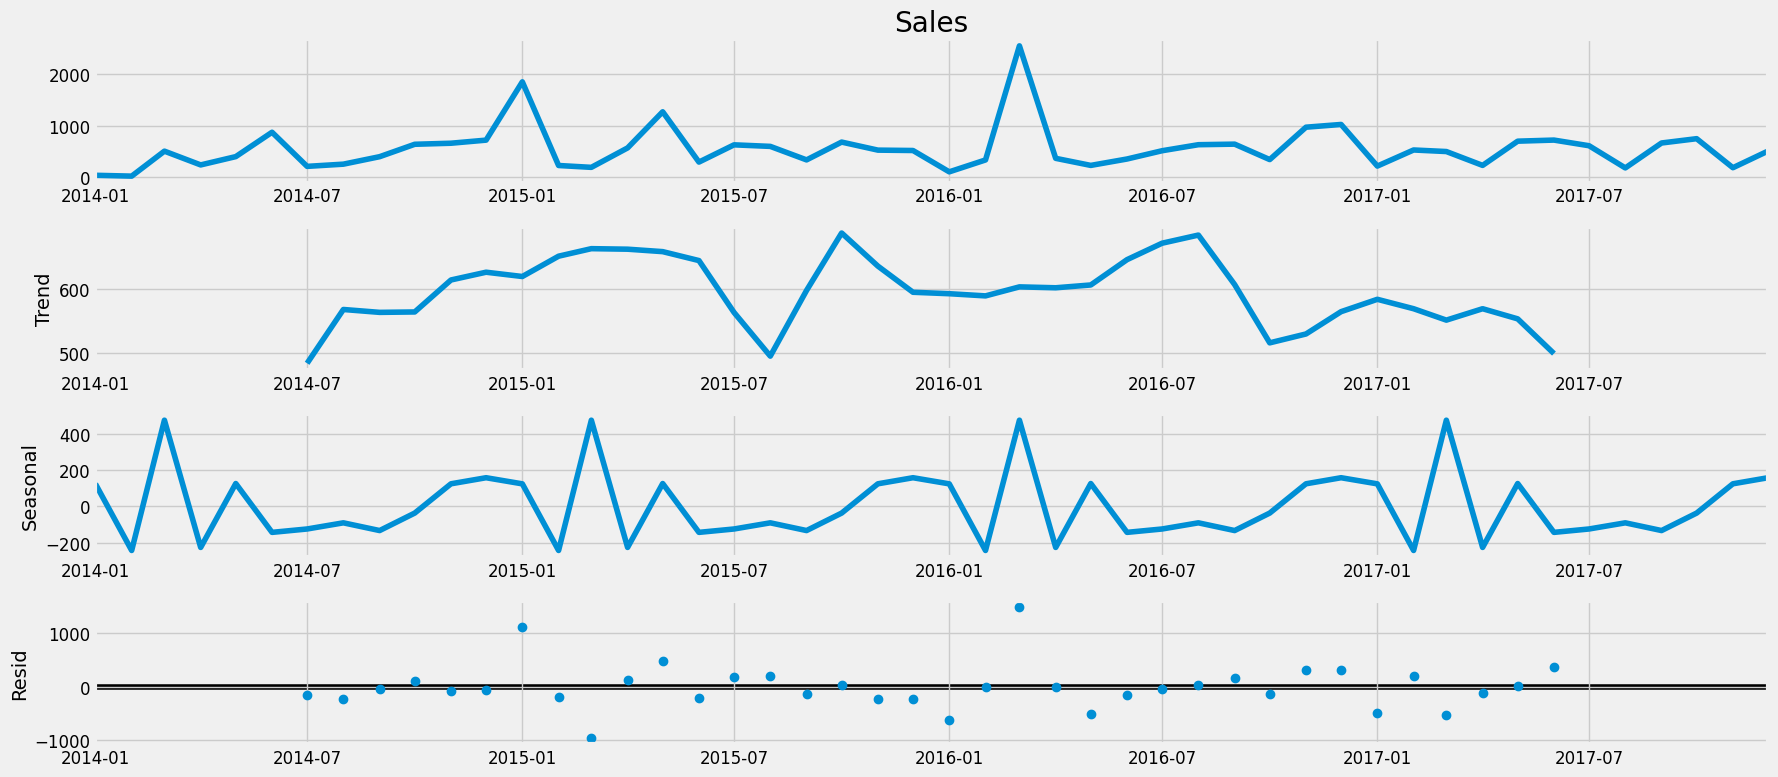

In [15]:
from pylab import rcParams

rcParams['figure.figsize'] = 18,8

#decompose seasonal data 
decomposition = sm.tsa.seasonal_decompose(y,model='additive')
fig = decomposition.plot()
plt.show()

###Split to train and test dataset 

In [16]:
def train_test_split_timeseries(X,y,test_size=0.2):
  split_size = int(len(X) * (1-test_size))
  X_train,y_train = X[:split_size],y[:split_size]
  X_test,y_test = X[split_size:],y[split_size:]
  
  return X_train,y_train,X_test,y_test 


In [137]:
def get_timeseries_metrics(y_true,y_pred):
  mae = tf.metrics.mean_absolute_error(y_true,y_pred)
  mse = tf.metrics.mean_squared_error(y_true,y_pred)
  rmse = tf.sqrt(mse)
  #mape = (100 / len(y_true)) * tf.abs(tf.reduce_sum((y_true-y_pred)/y_true))

  
  return {"mae":mae.numpy(),
          "mse":mse.numpy(),
          "rmse":rmse.numpy()}

In [48]:
timesteps = los_angeles_data.index.to_numpy()
sales = los_angeles_data['Sales'].to_numpy()

In [19]:
split_size = 0.9
X_train,y_train,X_test,y_test=train_test_split_timeseries(timesteps,sales)
len(X_train),len(y_train),len(X_test),len(y_test)

(264, 264, 67, 67)

#Naive Forecasting

In [139]:
naive_forecast = y_test[:-1]
naive_forecast

array([3359.952 ,  118.02  ,  171.288 ,   37.52  ,   60.622 , 1515.186 ,
        840.125 ,  184.41  ,  124.22  ,  956.8035, 1413.172 ,  640.949 ,
         87.92  ,  122.136 ,    5.94  , 1464.22  ,  479.984 ,   73.512 ,
       2012.302 ,   99.87  ,  418.296 ,   25.92  ,  148.02  ,  957.768 ,
       2088.066 ,   67.7   ,  557.83  ,  369.536 ,  174.8   ,   56.7   ,
       2911.784 ,  190.01  ,   15.51  ,  878.816 , 1365.48  ,    9.24  ,
         99.2   ,  159.98  , 1687.26  , 1324.574 ,   35.2   ,  441.72  ,
        715.19  ,  261.536 ,  168.1   ,   29.69  ,  241.424 ,  186.85  ,
         25.576 ,   34.24  ,  132.36  ,  323.71  ,  435.168 ,  193.896 ,
         55.488 ,  178.89  ,   11.76  ,  374.376 , 1096.488 ,  172.26  ,
         11.808 ,   51.99  ,   12.51  ,  474.95  , 2970.432 ,  424.172 ])

In [140]:
len(naive_forecast),len(y_test[1:])

(66, 66)

In [141]:
naive_result = get_timeseries_metrics(y_test[1:],naive_forecast)
naive_result

{'mae': 670.1901212121212,
 'mse': 1067513.8714691591,
 'rmse': 1033.2056288412095}

ARIMA FORECASTING

In [142]:
p=d=q = range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1],x[2],12) for x in pdq]

In [143]:
param_dict = {}
pdq_dict = {}
for param in pdq:
  for param_seasonal in seasonal_pdq:
    try:
      mod=sm.tsa.statespace.SARIMAX(y,
                                    order=param,
                                     seasonal_order = param_seasonal,
                                    enforce_stationary=False,
                                      enforce_invertibility=False)
      results=mod.fit()
      param_dict[param_seasonal] = results.aic
      pdq_dict[param] = results.aic
      print(f"ARIMA{param}x{param_seasonal}-AIC:{results.aic}")
   
    except:
      continue
    

ARIMA(0, 0, 0)x(0, 0, 0, 12)-AIC:767.2648550037876
ARIMA(0, 0, 0)x(0, 0, 1, 12)-AIC:1905.7296206518563
ARIMA(0, 0, 0)x(0, 1, 0, 12)-AIC:583.1096743790582
ARIMA(0, 0, 0)x(0, 1, 1, 12)-AIC:565.2910799446137
ARIMA(0, 0, 0)x(1, 0, 0, 12)-AIC:759.8948348898882
ARIMA(0, 0, 0)x(1, 0, 1, 12)-AIC:1950.5655820360412
ARIMA(0, 0, 0)x(1, 1, 0, 12)-AIC:567.4334250305234
ARIMA(0, 0, 0)x(1, 1, 1, 12)-AIC:564.7468919232512
ARIMA(0, 0, 1)x(0, 0, 0, 12)-AIC:756.4154200675387
ARIMA(0, 0, 1)x(0, 0, 1, 12)-AIC:1627.5123249324788
ARIMA(0, 0, 1)x(0, 1, 0, 12)-AIC:584.8934445927254
ARIMA(0, 0, 1)x(0, 1, 1, 12)-AIC:567.2730129966468
ARIMA(0, 0, 1)x(1, 0, 0, 12)-AIC:754.3061518580512
ARIMA(0, 0, 1)x(1, 0, 1, 12)-AIC:2128.177640426801
ARIMA(0, 0, 1)x(1, 1, 0, 12)-AIC:569.4321859109893
ARIMA(0, 0, 1)x(1, 1, 1, 12)-AIC:566.7468287533051
ARIMA(0, 1, 0)x(0, 0, 0, 12)-AIC:743.4024666770914
ARIMA(0, 1, 0)x(0, 0, 1, 12)-AIC:2275.047679943994
ARIMA(0, 1, 0)x(0, 1, 0, 12)-AIC:588.9911377674537
ARIMA(0, 1, 0)x(0, 1, 1, 12)

In [144]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1,1,1),
                                seasonal_order=(1,1,1,12),
                                enforce_stationary=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0088      0.247     -0.036      0.972      -0.492       0.475
ma.L1         -1.0002    199.377     -0.005      0.996    -391.771     389.771
ar.S.L12      -0.3507      0.184     -1.909      0.056      -0.711       0.009
ma.S.L12      -1.0000    199.427     -0.005      0.996    -391.870     389.870
sigma2      1.817e+05      0.001   1.65e+08      0.000    1.82e+05    1.82e+05


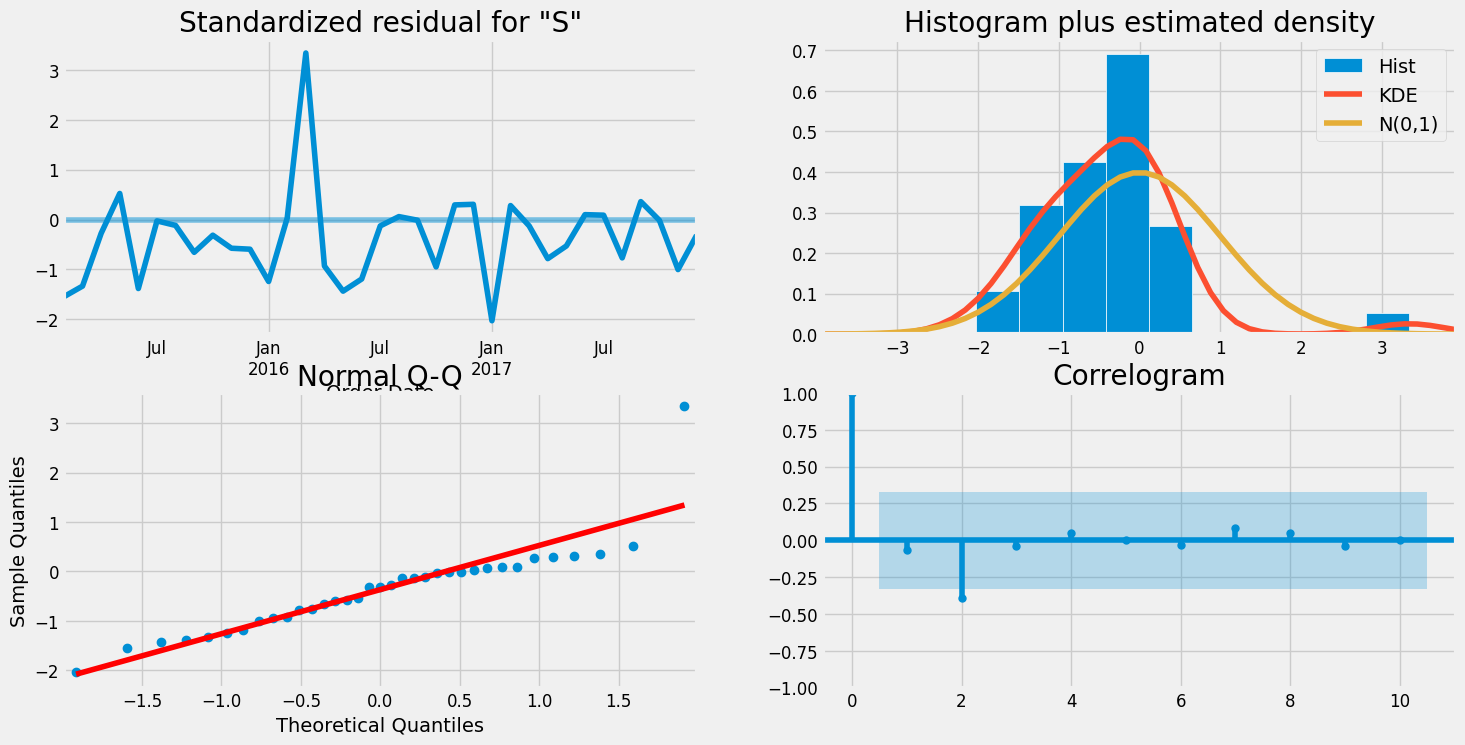

In [56]:
results.plot_diagnostics(figsize=(16,8))
plt.show()

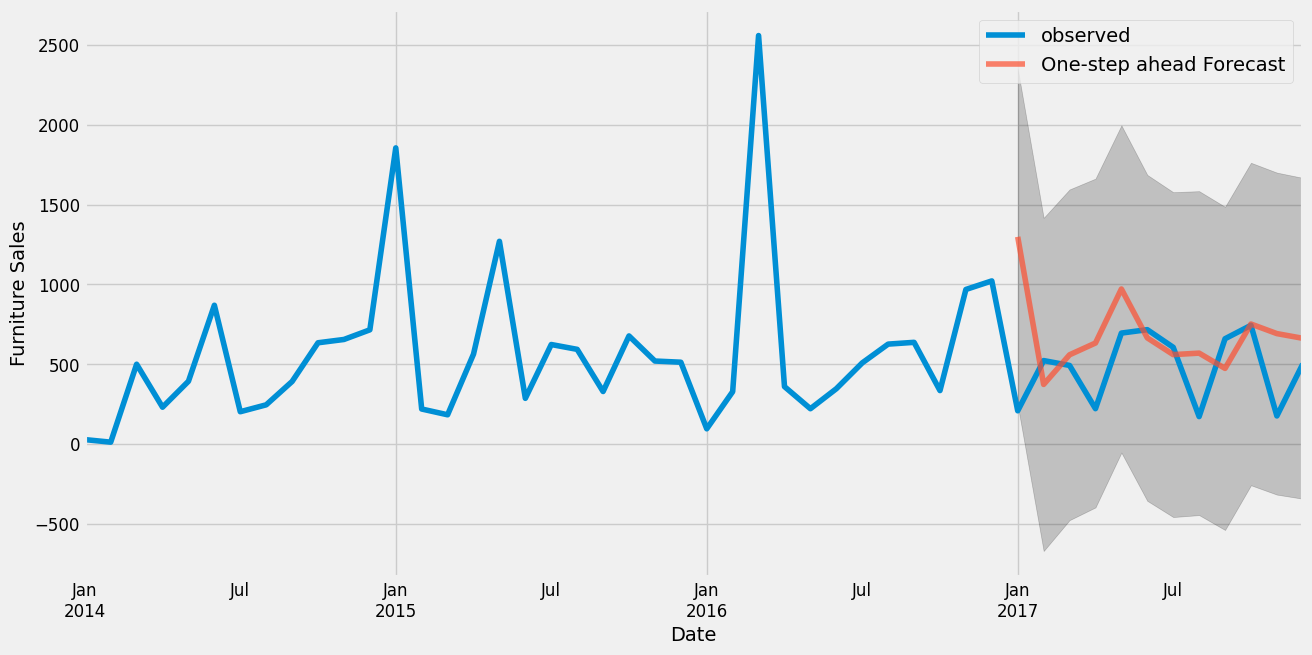

In [145]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'),
                              dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax,label='One-step ahead Forecast',
                         alpha=.7,figsize=(14,7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:,0],
                pred_ci.iloc[:,1],color='k',alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [146]:
arima_pred = pred.predicted_mean

In [147]:
pred_results = get_timeseries_metrics(y['2017-01-01':],arima_pred)
pred_results

{'mae': 279.57402031695517,
 'mse': 162060.8452131274,
 'rmse': 402.56781442774013}

### STACKED LSTM 

In [129]:
WINDOW_SIZE = 11
HORIZON = 1

In [130]:
def get_labelled_window(x,horizon):
  return x[:,:-horizon], x[:,-horizon:]

In [131]:
def make_windows(x,window_size = WINDOW_SIZE,horizon=HORIZON):
  window_step = np.expand_dims(np.arange(window_size+horizon),axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)),axis=0).T
  window_array = x[window_indexes]
  windows,label = get_labelled_window(window_array,horizon=horizon)    
  return windows,label                                     

In [132]:
full_windows,full_labels = make_windows(sales,window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_windows),len(full_labels)

(320, 320)

In [133]:
train_windows,train_labels,test_windows,test_labels = train_test_split_timeseries(full_windows,
                                                                                  full_labels,
                                                                                  test_size=0.1)

In [107]:
#creating training data
train_windows = tf.data.Dataset.from_tensor_slices(train_windows)
train_labels = tf.data.Dataset.from_tensor_slices(train_labels)

#create testing data
test_windows = tf.data.Dataset.from_tensor_slices(test_windows)
test_labels = tf.data.Dataset.from_tensor_slices(test_labels)

#zip feature and labels 
train_dataset = tf.data.Dataset.zip((train_windows,train_labels))
test_dataset = tf.data.Dataset.zip((test_windows,test_labels))

In [108]:
#Data pipelining for better performance
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [109]:
EPOCHS = 5000


## CUSTOM STACKED LSTM LAYERS

In [112]:
tf.random.set_seed(42)
inputs = tf.keras.layers.Input(shape = WINDOW_SIZE)
x = tf.keras.layers.Lambda(lambda x :tf.expand_dims(x,axis=1))(inputs)
x = tf.keras.layers.LSTM(32,activation="relu",return_sequences=True)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.LSTM(512,activation="relu",return_sequences=True)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.LSTM(512,activation="relu",return_sequences=True)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.LSTM(512,activation="relu",return_sequences=True)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.LSTM(1024,activation="relu",return_sequences=True)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.LSTM(1024,activation="relu",return_sequences=True)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.LSTM(1024,activation="relu",return_sequences=True)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.LSTM(1024,activation="relu",return_sequences=True)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.LSTM(1024,activation="relu",return_sequences=True)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.LSTM(1024,activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64,activation="relu")(x)
outputs = tf.keras.layers.Dense(HORIZON,activation="linear")(x)

stacked_lstm = tf.keras.Model(inputs = inputs,outputs=outputs)
stacked_lstm.compile(loss="mae",
                     optimizer = tf.keras.optimizers.Adam())

stacked_lstm.fit(train_dataset,
                 epochs = EPOCHS,
                 #batch_size = BATCH_SIZE,
                 validation_data=test_dataset,
                 callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                               patience = 100,
                                                               restore_best_weights=True)]
                                                               )


Epoch 1/5000
9/9 [==============================] - 19s 256ms/step - loss: 556.1504 - val_loss: 407.1989
Epoch 2/5000
9/9 [==============================] - 1s 68ms/step - loss: 665.0549 - val_loss: 406.4125
Epoch 3/5000
9/9 [==============================] - 1s 70ms/step - loss: 554.0099 - val_loss: 396.6507
Epoch 4/5000
9/9 [==============================] - 1s 72ms/step - loss: 523.7742 - val_loss: 377.2674
Epoch 5/5000
9/9 [==============================] - 1s 74ms/step - loss: 508.2141 - val_loss: 358.7589
Epoch 6/5000
9/9 [==============================] - 0s 56ms/step - loss: 492.7586 - val_loss: 364.1132
Epoch 7/5000
9/9 [==============================] - 0s 55ms/step - loss: 510.2169 - val_loss: 385.3699
Epoch 8/5000
9/9 [==============================] - 1s 59ms/step - loss: 505.5280 - val_loss: 384.6624
Epoch 9/5000
9/9 [==============================] - 1s 60ms/step - loss: 520.8948 - val_loss: 377.2191
Epoch 10/5000
9/9 [==============================] - 1s 68ms/step - los

In [ ]:
stacked_lstm=joblib.load("/content/gdrive/MyDrive/DeepStackedLSTM10.pkl")

In [ ]:
load_model_DeepStackedLSTM10 = joblib.load()

In [123]:
stacked_lstm.evaluate(test_dataset)

1/1 [==============================] - 0s 30ms/step - loss: 268.1750


268.17498779296875

In [84]:
def make_pred(model,input_data):
  pred = model.predict(input_data)
  return tf.squeeze(pred)


In [125]:
stacked_lstm_pred = make_pred(stacked_lstm,test_dataset)
stacked_lstm_pred[:10]

1/1 [==============================] - 5s 5s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 175.78252 ,   44.03712 ,  226.02522 , 1553.3893  ,  183.23067 ,
        630.77606 ,  546.7149  ,   20.629448,  245.8057  ,   28.247833],
      dtype=float32)>

In [138]:
stacked_lstm_result = get_timeseries_metrics(tf.squeeze(test_labels),stacked_lstm_pred)
stacked_lstm_result

{'mae': 268.175, 'mse': 217920.0, 'rmse': 466.81903}

### Bidirectional Algorithm

In [114]:
BATCH_SIZE = 32

In [117]:
tf.random.set_seed(42)

inputs = tf.keras.layers.Input(shape=WINDOW_SIZE)
x = tf.keras.layers.Lambda(lambda x:tf.expand_dims(x,axis=1))(inputs)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,activation="relu",return_sequences=True))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,activation = "relu",return_sequences=True))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,activation = "relu",return_sequences=True))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,activation = "relu",return_sequences=True))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,activation = "relu",return_sequences=True))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,activation = "relu",return_sequences=True))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024,activation = "relu",return_sequences=True))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024,activation = "relu",return_sequences=True))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024,activation = "relu",return_sequences=True))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024,activation = "relu"))(x)
x = tf.keras.layers.Dense(32,activation="relu")(x)
outputs = tf.keras.layers.Dense(HORIZON,activation="linear")(x)

model_bidirectional = tf.keras.Model(inputs=inputs,outputs=outputs)

model_bidirectional.compile(loss="mae",
                            optimizer = tf.keras.optimizers.Adam())

model_bidirectional.fit(train_dataset,
                        epochs = EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_data = (test_dataset),
                        callbacks =[ tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                                     patience = 100,
                                                                     restore_best_weights=True)]
                        )

Epoch 1/5000
9/9 [==============================] - 41s 528ms/step - loss: 697.0767 - val_loss: 403.1926
Epoch 2/5000
9/9 [==============================] - 1s 141ms/step - loss: 518.5527 - val_loss: 352.2042
Epoch 3/5000
9/9 [==============================] - 1s 97ms/step - loss: 533.3676 - val_loss: 390.8083
Epoch 4/5000
9/9 [==============================] - 1s 97ms/step - loss: 512.0826 - val_loss: 360.8726
Epoch 5/5000
9/9 [==============================] - 1s 94ms/step - loss: 506.2860 - val_loss: 357.1961
Epoch 6/5000
9/9 [==============================] - 1s 100ms/step - loss: 532.0048 - val_loss: 382.0587
Epoch 7/5000
9/9 [==============================] - 1s 92ms/step - loss: 506.1591 - val_loss: 366.1857
Epoch 8/5000
9/9 [==============================] - 1s 95ms/step - loss: 507.5970 - val_loss: 368.7618
Epoch 9/5000
9/9 [==============================] - 1s 106ms/step - loss: 511.4697 - val_loss: 372.4045
Epoch 10/5000
9/9 [==============================] - 1s 98ms/step - 

In [119]:
model_bidirectional.evaluate(test_dataset)

1/1 [==============================] - 0s 64ms/step - loss: 346.5274


346.52740478515625

In [148]:
bidirectional_pred = make_pred(model_bidirectional,test_windows)

1/1 [==============================] - 3s 3s/step


In [149]:
bidirectional_results = get_timeseries_metrics(tf.squeeze(test_labels),bidirectional_pred)
bidirectional_results

{'mae': 346.5274, 'mse': 446985.88, 'rmse': 668.57}

### N-BEATS ALGORITHM

In [150]:
WINDOW_SIZE = 3
HORIZON = 1

In [151]:
los_angeles_nbeats = los_angeles_data.copy()
los_angeles_nbeats.head()

,Sales
Order Date,
2014-01-06,19.440
2014-01-20,38.660
2014-02-20,12.960
2014-03-23,935.152
2014-03-26,66.300


In [152]:
for i in range(WINDOW_SIZE):
  los_angeles_nbeats[f"Sales {i+1}"] = los_angeles_nbeats["Sales"].shift(periods=i+1)
los_angeles_nbeats

,Sales,Sales 1,Sales 2,Sales 3
Order Date,,,,
2014-01-06,19.440,NaN,NaN,NaN
2014-01-20,38.660,19.440,NaN,NaN
2014-02-20,12.960,38.660,19.440,NaN
2014-03-23,935.152,12.960,38.660,19.440
2014-03-26,66.300,935.152,12.960,38.660
...,...,...,...,...
2017-12-21,12.510,51.990,11.808,172.260
2017-12-22,474.950,12.510,51.990,11.808
2017-12-24,2970.432,474.950,12.510,51.990


In [153]:
x = los_angeles_nbeats.dropna().drop("Sales",axis = 1)
y = los_angeles_nbeats.dropna()["Sales"]

In [154]:
X_train,y_train,X_test,y_test = train_test_split_timeseries(x,
                                                            y)
len(X_train), len(y_train), len(X_test), len(y_test)

(262, 262, 66, 66)

In [155]:
print(X_train.shape),print(y_train.shape),print(X_test.shape),print(y_test.shape)

(262, 3)
(262,)
(66, 3)
(66,)


(None, None, None, None)

In [156]:
# train features and labels
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

# test featuresn and labels
test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# zipping features and labels to tuple
train_dataset = tf.data.Dataset.zip((train_features_dataset,train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset,test_labels_dataset))

In [157]:
BATCH_SIZE = 32
# data pipeline and prefetch
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [158]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size :int,
               theta_size :int,
               horizon : int,
               n_neurons :int,
               n_layers :int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_layers = n_layers
    self.n_neurons = n_neurons

    #Block contains 4 fully connected layers with each relu activations
    self.hidden = [tf.keras.layers.Dense(n_neurons,activation="relu") for _ in range(n_layers) ]
    # output of block is theta layer theta_backcast, theta_forecast
    self.theta_layer = tf.keras.layers.Dense(theta_size,activation="linear")
  
  def call(self,inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
      #x = tf.keras.layers.Dropout(0.5)(x)

    theta = self.theta_layer(x)
    # Output backcast and forecast
    backcast,forecast = theta[:,:self.input_size],theta[:,-self.horizon:]
    return backcast,forecast
  
  


    
    

In [159]:

EPOCHS = 5000
N_STACKS = 30
N_NEURONS = 512
N_LAYERS = 4

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = WINDOW_SIZE + HORIZON
INPUT_SIZE,THETA_SIZE

(3, 4)

In [160]:
%time
tf.random.set_seed(42)

# Set up instances
nbeats_block_layer = NBeatsBlock(input_size = INPUT_SIZE,
                                 theta_size = THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons = N_NEURONS,
                                 n_layers = N_LAYERS,
                                 name="InitialBlck")


# Create input to stack
stack_input = tf.keras.layers.Input(shape=INPUT_SIZE,name="stack_input")

# Create initial backcast and forecast (backcast + forecast)
backcast,forecast = nbeats_block_layer(stack_input)

residuals = tf.keras.layers.subtract([stack_input,backcast],name="subtract_00")

# Create stack of block layers
for i,_ in enumerate(range(N_STACKS-1)):

  # Use the NBeatsBlock to calculate the backcast as well the forecast
  backcast, block_forecast = NBeatsBlock(
      input_size = INPUT_SIZE,
      theta_size = THETA_SIZE,
      horizon = HORIZON,
      n_neurons = N_NEURONS,
      n_layers = N_LAYERS,
      name = f"NBeatsBlock_{i}"
  )(residuals)


  # Create  double resiudal stacking
  residuals = tf.keras.layers.subtract([residuals,backcast],name=f"subtracted_{i}")
  forecast = tf.keras.layers.add([forecast,block_forecast],name=f"add_{i}")

n_beats_model = tf.keras.Model(inputs = stack_input,outputs = forecast)

n_beats_model.compile(loss="mae",
                      optimizer = tf.keras.optimizers.Adam())

n_beats_model.fit(train_dataset,
                  epochs=EPOCHS,
                  validation_data=test_dataset,
                  callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                             patience=100,
                                                             restore_best_weights=True)])


CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.3 µs
Epoch 1/5000
9/9 [==============================] - 63s 336ms/step - loss: 2017.3700 - val_loss: 482.7698
Epoch 2/5000
9/9 [==============================] - 0s 55ms/step - loss: 522.3752 - val_loss: 497.4832
Epoch 3/5000
9/9 [==============================] - 1s 56ms/step - loss: 539.1978 - val_loss: 491.8509
Epoch 4/5000
9/9 [==============================] - 1s 75ms/step - loss: 522.5671 - val_loss: 469.3605
Epoch 5/5000
9/9 [==============================] - 0s 54ms/step - loss: 511.0871 - val_loss: 473.8173
Epoch 6/5000
9/9 [==============================] - 0s 54ms/step - loss: 510.2310 - val_loss: 474.9458
Epoch 7/5000
9/9 [==============================] - 1s 74ms/step - loss: 501.4242 - val_loss: 456.1531
Epoch 8/5000
9/9 [==============================] - 1s 70ms/step - loss: 492.4407 - val_loss: 431.6249
Epoch 9/5000
9/9 [==============================] - 0s 56ms/step - loss: 500.0222 - val_loss: 459.7407
Epo

In [161]:
n_beats_model.evaluate(test_dataset)

3/3 [==============================] - 0s 13ms/step - loss: 402.6703


402.6703186035156

In [162]:
n_beats_pred = make_pred(n_beats_model,test_dataset)

3/3 [==============================] - 1s 10ms/step


In [163]:
n_beats_results = get_timeseries_metrics(y_test,n_beats_pred)
n_beats_results

{'mae': 402.67032, 'mse': 501947.5, 'rmse': 708.48254}

In [164]:
n_beats_df = pd.DataFrame()

### COMPARING TIME SERIES MODELS RESULTS

In [165]:
model_list = ['Naive Model','ARIMA Model','DeepStackedLSTM10','DeepStackedBidirectionalLSTM','NBeats Algortihm']
mae_score = [naive_result['mae'],pred_results['mae'],stacked_lstm_result['mae'],bidirectional_results['mae'],n_beats_results['mae']]

In [167]:
timeseries_results = pd.DataFrame({"Model Name":model_list,
                                   "Mae Score":mae_score})

In [193]:
timeseries_results = timeseries_results.sort_values(by="Mae Score",ascending=True,ignore_index=True)
timeseries_results

,Model Name,Mae Score
0,DeepStackedLSTM10,268.174988
1,ARIMA Model,279.574020
2,DeepStackedBidirectionalLSTM,346.527405
3,NBeats Algortihm,402.670319
4,Naive Model,670.190121


### CREATING FORECASTING INTERVAL USING BEST MODEL

In [186]:
def get_upper_and_lower(preds,results):
  mae = results['mae']

  # Multiply std by 1.96 (95% CI from mean ) 
  interval = 1.96 * mae

  # get lower and upper prediction
  lower,upper = preds - interval,preds + interval

  return lower,upper

In [188]:
lower,upper = get_upper_and_lower(preds=stacked_lstm_pred,results=stacked_lstm_result)

**DeepStackedLSTM10** is the **best model** (lowest mse score) for forecasting sales in Los Angeles

# Visualizing Real Sales and Forecast Sales using DeepStackedLSTM10

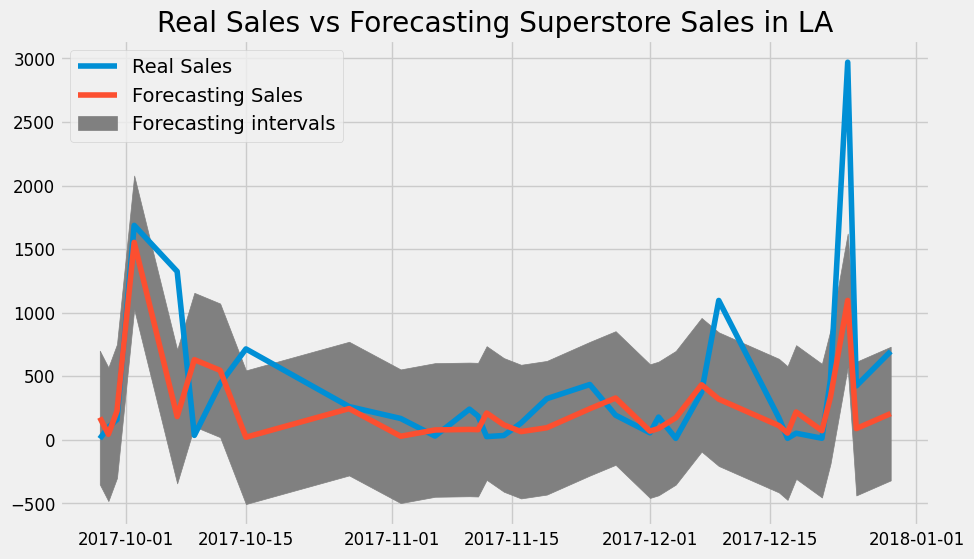

In [190]:
offset = len(X_test)-stacked_lstm_pred.shape[0]
plt.figure(figsize = (10,6))
plt.plot(X_test.index[offset:],y_test[offset:],label = "Real Sales")
plt.plot(X_test.index[offset:],stacked_lstm_pred,label = "Forecasting Sales")
plt.fill_between(X_test.index[offset:],
        (lower),
        (upper),
         label = "Forecasting intervals",
         color='grey')
plt.title("Real Sales vs Forecasting Superstore Sales in LA")
plt.legend()
plt.show()